In [1]:
from spks import *
import numpy as np
from pathlib import Path
sys.path.append('/home/joao/lib/dredge/dredge-python/')
from dredge.dredge_ap import register
from labdata.schema import * 


import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 16})

[2024-05-13 16:42:23,188][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-05-13 16:42:23,541][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [8]:
SUBJECTS = ['_CSH_ZAD_026','_CSH_ZAD_026','MM008','MM008','MM012','MM012']
SESSIONS = ['2020-08-15/001',
            '2020-08-19/001',
            '2023-03-23/001',
            '2023-06-09/001',
            '2023-08-15/001',
            '2023-10-25/003']
PROBENUM = [0,0,1,1,1,1]

#SUBJECTS = [SUBJECTS[0]] # for testing
#SESSIONS = [SESSIONS[0]]
#PROBENUM = [PROBENUM[0]]

#KILOSORT_PARAMETER_SET_NUM = 8 # KS4, no motion correction
KILOSORT_PARAMETER_SET_NUM = 5 # KS4, with motion correction

labels = ['Acute session 1',
          'Acute session 2',
          'Chronic implant 1\nWeek 1',
          'Chronic implant 1\nWeek 11',
          'Chronic implant 2\nWeek 1',
          'Chronic implant 2\nWeek 10']

base_query = SpikeSorting.Unit * EphysRecording.ProbeSetting()

In [3]:
spike_data, registrations = [],[]
for (sname, sdate, pnum) in zip(SUBJECTS, SESSIONS, PROBENUM):
    query_dict = dict(parameter_set_num=KILOSORT_PARAMETER_SET_NUM,
                      probe_num=pnum,
                      subject_name=sname,
                      session_name=sdate)
    units_query = base_query & query_dict
    print(f'Running {sname} {sdate} probe {pnum}')
    srate = units_query.fetch('sampling_rate', limit=1)[0]
    times, positions, amps = units_query.fetch('spike_times', 'spike_positions','spike_amplitudes')

    times = np.concatenate(times) / srate
    amps = np.concatenate(amps)
    positions = np.concatenate(positions)[:,1]

    spike_data.append(dict(times=times, positions=positions, amps=amps))

    #motion_est, _ = register(amps, positions, times)
    motion_est, _ = register(amps, positions, times)
    registrations.append(motion_est)
    

Running _CSH_ZAD_026 2020-08-15/001 probe 0


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Running _CSH_ZAD_026 2020-08-19/001 probe 0


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Running MM008 2023-03-23/001 probe 1


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Running MM008 2023-06-09/001 probe 1


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Running MM012 2023-08-15/001 probe 1


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Running MM012 2023-10-25/003 probe 1


Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Weights:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

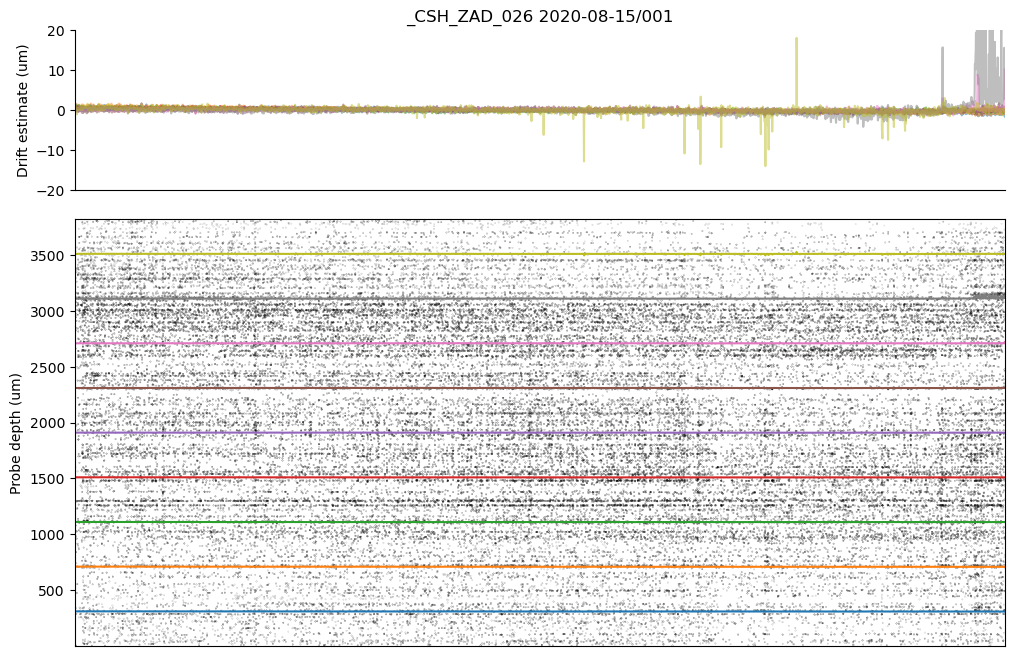

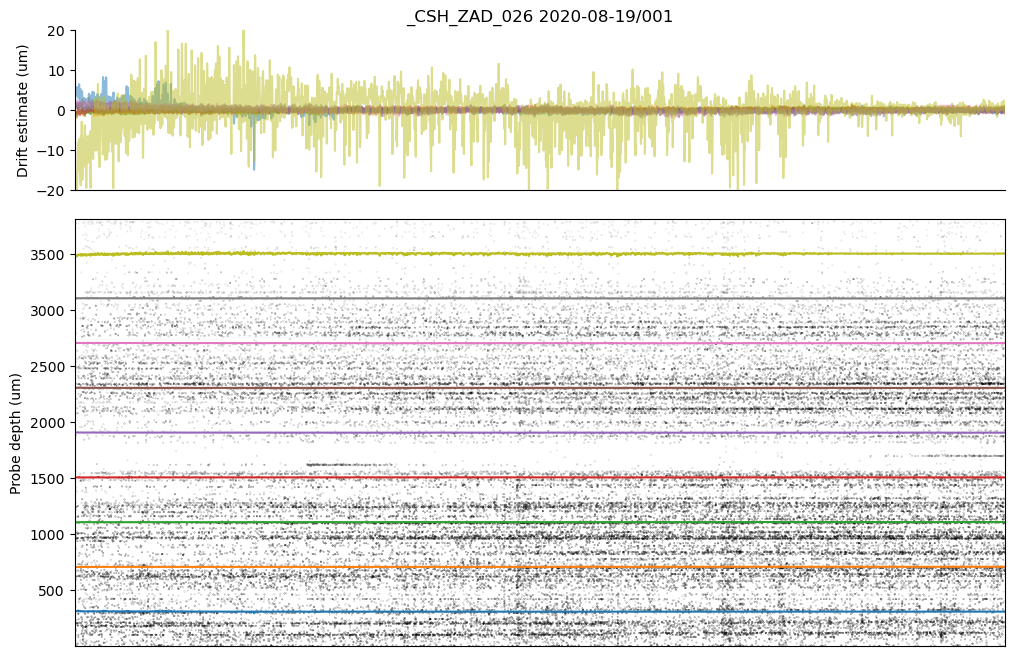

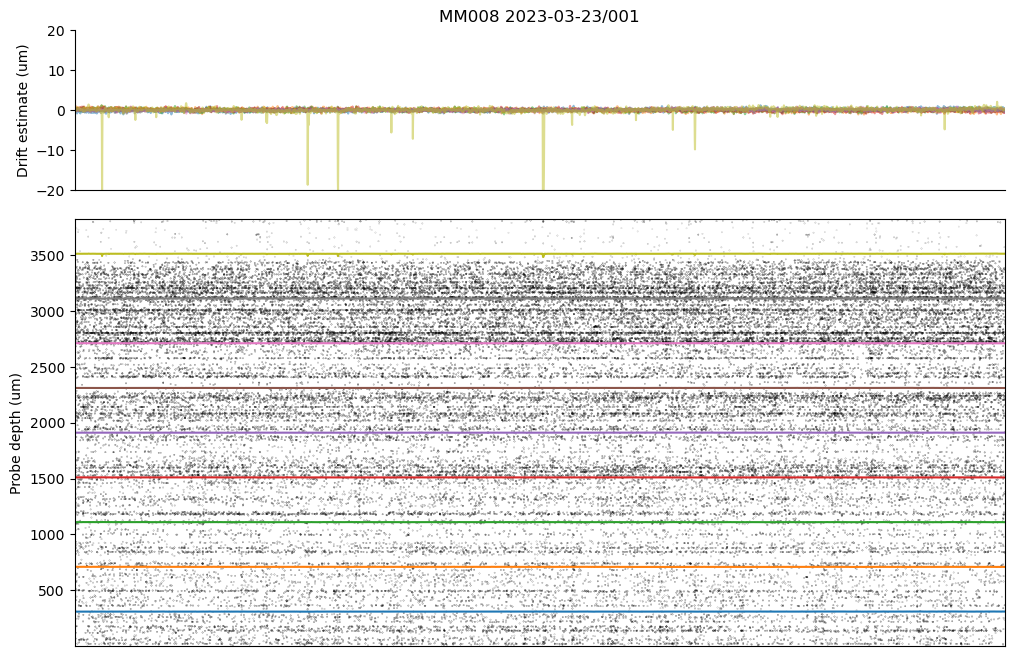

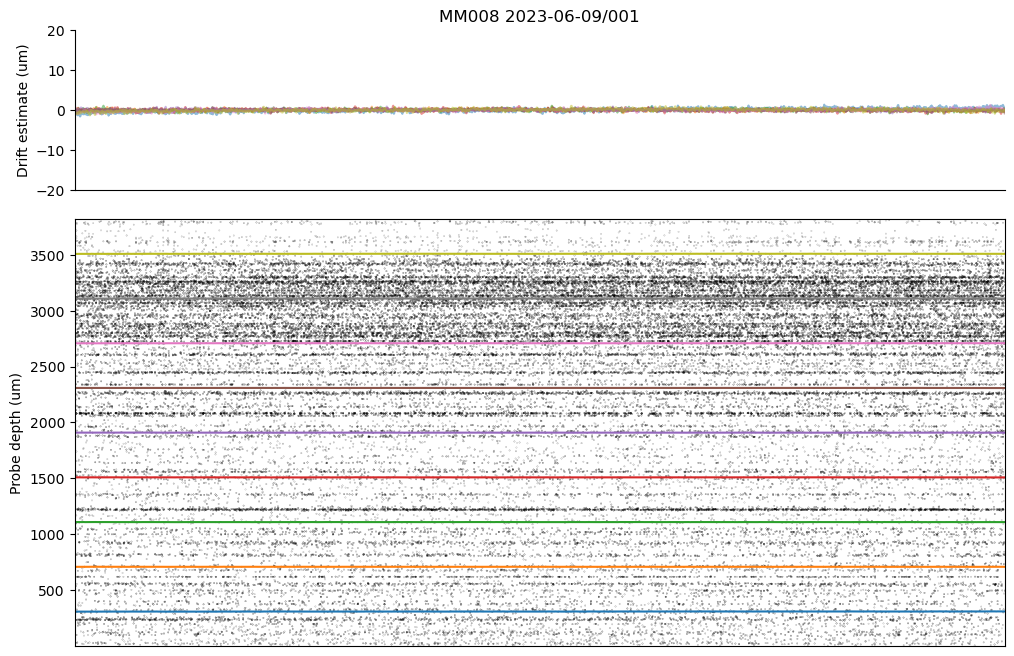

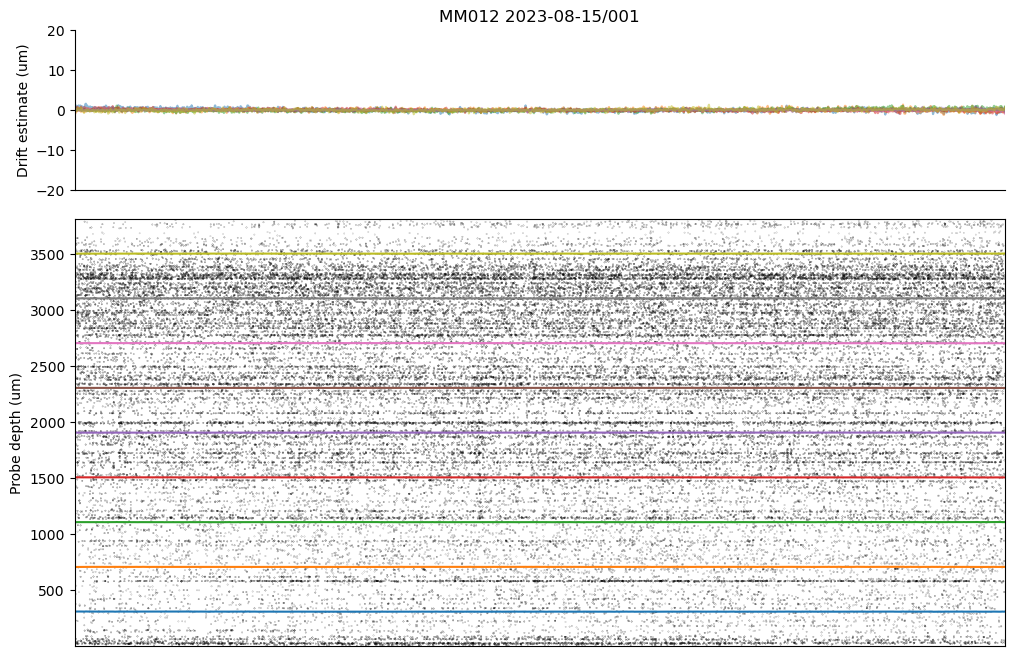

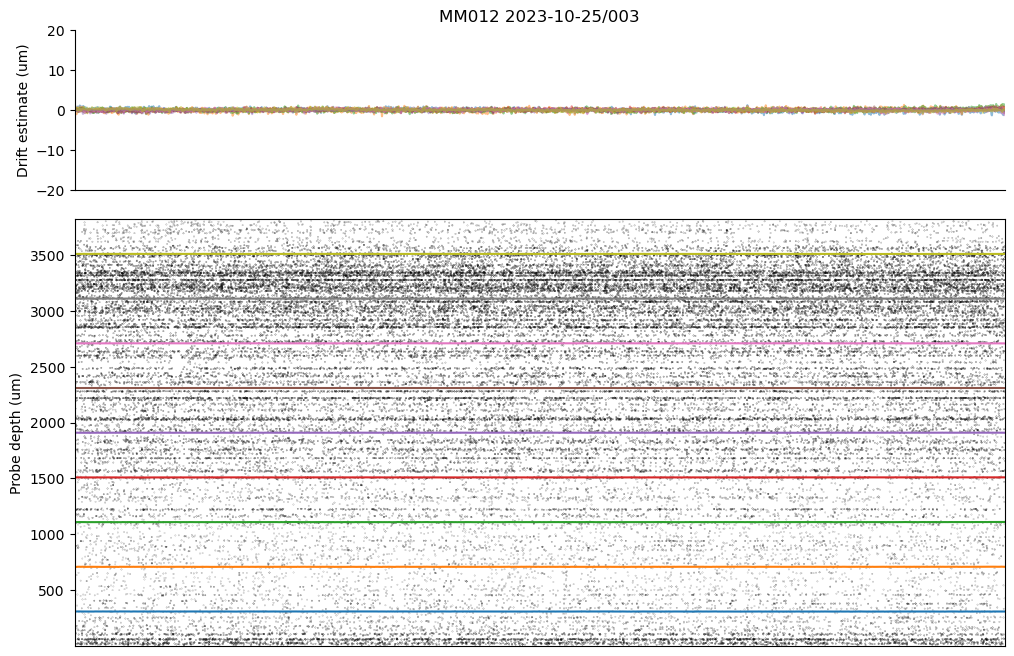

In [4]:
from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         wspace=.2,
                         hspace=.1,height_ratios=[.75,2])
for i,(spikes,motion_est) in enumerate(zip(spike_data, registrations)):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(spec[1])
    plot_drift_raster(spikes['times'],
                      spikes['positions'],
                      spikes['amps'],
                      n_spikes_to_plot=50_000,
                      clim=[0,500],
                      cmap='gray_r',
                      rasterized=True)
    plt.plot(motion_est.time_bin_centers_s, motion_est.displacement.T + motion_est.spatial_bin_centers_um)
    plt.ylabel('Probe depth (um)')

    fig.add_subplot(spec[0], sharex=ax)
    plt.plot(motion_est.time_bin_centers_s, motion_est.displacement.T, alpha=.5)
    plt.xticks([])
    plt.ylim(-20,20)
    plt.ylabel('Drift estimate (um)')
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.title(f'{SUBJECTS[i]} {SESSIONS[i]}')


In [5]:
# Quantify DREDGE traces
all_var = []
for isess, motion_est in enumerate(registrations):
    sess_var = []
    motion = motion_est.displacement
    #variance = np.var(motion,axis=1)
    variance = np.std(motion,axis=1)
    #variance = np.mean(np.abs(np.diff(motion, axis=1)), axis=1)
    all_var.append(variance)
all_var = np.stack(all_var)
print(all_var.shape)

(6, 9)


[]

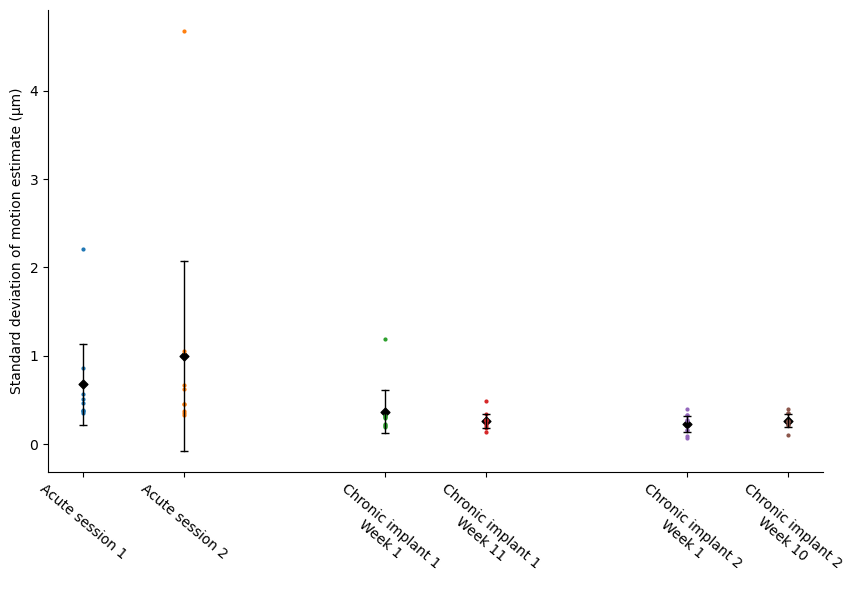

In [6]:
xvals = [0, .5, 1.5, 2, 3, 3.5]
#error = [np.std(i) / np.sqrt(len(i)) for i in all_var] # SEM
import scipy.stats as st
ci_95 = [st.t.interval(.95, df=len(d)-1, loc=np.mean(d), scale=st.sem(d))  for d in all_var] # create 95% confidence interval 
fig = plt.figure(figsize=(10,6))

#plt.errorbar(xvals, np.mean(all_var, axis=1), yerr=ci_95, markersize=5, capsize=8, marker='D', linestyle='none', color='black')
plt.scatter(xvals, np.mean(all_var, axis=1), s=20, marker='D', color='black')
for i,e in enumerate(ci_95):
    plt.plot(xvals[i]*np.array([1,1]),e,'_-',lw=1,color='black')
for i,x in enumerate(xvals):
    plt.scatter([x]*len(all_var[i]), all_var[i], s=4)

#plt.gca().set_xticklabels(labels)
plt.ylabel('Standard deviation of motion estimate (μm)')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xticks(xvals, labels, rotation=-40)
#plt.ylim(0,4)
plt.plot()
#plt.savefig(SAVEPATH / 'quantify_dredge_traces.pdf', format='pdf', dpi=500, bbox_inches='tight')

In [7]:
from scipy import stats
for i in range(all_var.shape[0]):
    for j in range(i, all_var.shape[0]):
        if i==j:
            continue
        #t, p = stats.ttest_rel(all_var[i,:],all_var[j,:])
        #t, p = stats.ks_2samp(all_var[i,:],all_var[j,:])
        t, p = stats.mannwhitneyu(all_var[i,:],all_var[j,:])
        print(f'p value for indices {i} {j}: {p}')

p value for indices 0 1: 1.0
p value for indices 0 2: 0.004718198728115028
p value for indices 0 3: 0.0019976900972723025
p value for indices 0 4: 0.0014784647972275091
p value for indices 0 5: 0.0014784647972275091
p value for indices 1 2: 0.004718198728115028
p value for indices 1 3: 0.0026797144168214833
p value for indices 1 4: 0.0014784647972275091
p value for indices 1 5: 0.0026797144168214833
p value for indices 2 3: 0.5364994693194564
p value for indices 2 4: 0.47992869214595724
p value for indices 2 5: 1.0
p value for indices 3 4: 0.6588432549492806
p value for indices 3 5: 0.7910815129207817
p value for indices 4 5: 0.5962416305866567


### Plot waveform amplitudes and yields

In [5]:
UnitCountCriteria()

*unit_criteria sua_criteria   mua_criteria  
+------------+ +------------+ +------------+
1              isi_contaminat None          
2              isi_contaminat None          
3              isi_contaminat None          
4              isi_contaminat None          
 (Total: 4)

In [9]:
UNIT_CRITERIA_ID = 2
#UnitMetrics().populate(processes=120, display_progress=True)
#UnitCount().populate(display_progress=True)
unit_metrics_query = UnitCount.Unit() & dict(parameter_set_num=KILOSORT_PARAMETER_SET_NUM,
                                             unit_criteria_id=UNIT_CRITERIA_ID)
#unit_metrics_query = UnitCount.Unit() & dict(parameter_set_num=4,
#                                             unit_criteria_id=UNIT_CRITERIA_ID)

In [10]:
dat = []
for (sname, sdate, pnum) in zip(SUBJECTS, SESSIONS, PROBENUM):
    query_dict = dict(probe_num=pnum,
                      subject_name=sname,
                      session_name=sdate)
                      
    print(f'Running {sname} {sdate} probe {pnum}')
    #srate = (EphysRecording().ProbeSetting() & query_dict).fetch1('sampling_rate')
    units = (unit_metrics_query & query_dict) * UnitMetrics()
    dat.extend(units.fetch('subject_name','session_name','unit_id','passes','spike_amplitude',as_dict=True))
dat = pd.DataFrame(dat)

Running _CSH_ZAD_026 2020-08-15/001 probe 0
Running _CSH_ZAD_026 2020-08-19/001 probe 0
Running MM008 2023-03-23/001 probe 1
Running MM008 2023-06-09/001 probe 1
Running MM012 2023-08-15/001 probe 1
Running MM012 2023-10-25/003 probe 1


In [8]:
#dat.head()
pd.pivot_table(dat, values='passes', index=['subject_name','session_name'], aggfunc=np.sum)

/tmp/ipykernel_1241421/3821538104.py:2: FutureWarning: The provided callable <function sum at 0x7f8efcadb9c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(dat, values='passes', index=['subject_name','session_name'], aggfunc=np.sum)


passes
subject_name session_name          
MM008        2023-03-23/001     262
             2023-06-09/001     191
MM012        2023-08-15/001     240
             2023-10-25/003     237
_CSH_ZAD_026 2020-08-15/001     159
             2020-08-19/001     126

In [9]:
import matplotlib.patches as mpatches
i,x = 0,0
fdict = {'size': 12}
leg_labels, xticks = [],[]

sessions = dat[['subject_name','session_name']].drop_duplicates() # unique sessions
fig = plt.figure(figsize=(24,8))
#for i,session_data in dat.groupby(['subject_name','session_name']):
for i,sess in sessions.iterrows():
    session_data = dat[(dat.subject_name == sess.subject_name) & (dat.session_name == sess.session_name)]
    all_amps = session_data.spike_amplitude.values
    scatter_positions = np.random.normal(x, scale=.05, size=len(all_amps))
    parts = plt.violinplot([all_amps],[x], showmedians=False, showextrema=False, showmeans=False)
    plt.scatter(scatter_positions, all_amps, s=5, color='black', alpha=.8)
    plt.hlines(np.median(all_amps), x-.3, x+.3, color='black')
    plt.text(x-.1,800,f'{len(all_amps)}',fontdict=fdict)
    xticks.append(x+.75/2)
    x += .75
    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    if i==0:
        color = parts['bodies'][0].get_facecolor().flatten()
        leg_labels.append((mpatches.Patch(color=color), 'All units'))

    su_amps = session_data[session_data.passes == 1].spike_amplitude.values
    scatter_positions = np.random.normal(x, scale=.05, size=len(su_amps))
    parts = plt.violinplot([su_amps],[x], showmedians=False, showextrema=False, showmeans=False)
    plt.scatter(scatter_positions, su_amps, s=5, color='black', alpha=.8)
    plt.hlines(np.median(su_amps), x-.3, x+.3, color='black')
    plt.text(x-.1,800,f'{len(su_amps)}',fontdict=fdict)
    x += 1.5
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    if i==0:
        color = parts['bodies'][0].get_facecolor().flatten()
        leg_labels.append((mpatches.Patch(color=color), 'Single units'))
    i += 1

plt.xticks(xticks, labels)
plt.xticks(rotation=-30)
plt.ylabel('Cluster amplitudes')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend(*zip(*leg_labels), loc = 1)
plt.show()

<IPython.core.display.Javascript object>

/opt/conda/envs/spks/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [10]:
# Plot n single units
fig = plt.figure(figsize=(8,5))
xvals = [0,.5, 1.5, 2, 3, 3.5]

n_sua = []
for i,sess in sessions.iterrows():
    session_data = dat[(dat.subject_name == sess.subject_name) & (dat.session_name == sess.session_name)]
    n_sua.append(len(session_data[session_data.passes == 1]))

plt.scatter(xvals, n_sua, color='black', s=25)
plt.plot(xvals[2:4], n_sua[2:4], color='black')
plt.plot(xvals[4:6], n_sua[4:6], color='black')

plt.ylim([0,300])
plt.xticks(xvals, labels)
plt.xticks(rotation=-30)
plt.ylabel('N single units')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)

<IPython.core.display.Javascript object>

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
from labdata.schema import *

l = 3
q = SpikeSorting.Waveforms() *  SpikeSorting * units & 'spike_amplitude = 0'
d = q.fetch('waveform_median','channel_coords', 'active_electrodes',as_dict=True)[l]
print(d['channel_coords'].shape)

from spks.viz import plot_footprints
plot_footprints(d['waveform_median'], d['channel_coords'], srate=100000)
plt.show()

(383, 2)


<IPython.core.display.Javascript object>